## Neural Style Transfer

## Loading VGG Pretrained Model

In [44]:
import torch
from torchvision import models
vgg = models.vgg19(pretrained=True)
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [45]:
vgg = vgg.features
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [46]:
for parameters in vgg.parameters():
      parameters.requires_grad_(False)


In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu" )
print(device)
vgg.to(device)

cpu


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## Preprocess image

Torchvision models page : https://pytorch.org/docs/stable/torchvision/models.html

In [48]:
from PIL import Image
from torchvision import transforms as T

def preprocess(img_path,max_size = 500):

   image = Image.open(img_path).convert('RGB')

   if max(image.size) > max_size:
     size = max_size

   else:
     size = max(image.size)

   img_transforms = T.Compose([
                               
                    T.Resize(size),
                    T.ToTensor(),
                    T.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])           
   ])    

   image = img_transforms(image)

   image = image.unsqueeze(0)   #(3,224,224) -> (1,3,224,224)

   return image


In [49]:
#pre processed image

content_p = preprocess('content11.jpg')
style_p = preprocess('style12.jpg')

content_p = content_p.to(device)
style_p = style_p.to(device)

print("content shape", content_p.shape)
print("style shape", style_p.shape)


content shape torch.Size([1, 3, 259, 345])
style shape torch.Size([1, 3, 625, 500])


## Deprocess image

In [50]:
# Deprocess function

import numpy as np
import matplotlib.pyplot as plt

def deprocess(tensor):

  image = tensor.to('cpu').clone()
  image = image.numpy()
  image = image.squeeze(0) #(1,3,224,224) -> (3,224,224)
  image = image.transpose(1,2,0)  #(3,224,224) -> (224,224,3)
  image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
  image = image.clip(0,1)

  return image

In [51]:
# deprocess the image

content_d = deprocess(content_p)
style_d = deprocess(style_p)

print("Deprocess content : ",content_d.shape)
print("Deprocess style : ", style_d.shape)

Deprocess content :  (259, 345, 3)
Deprocess style :  (625, 500, 3)


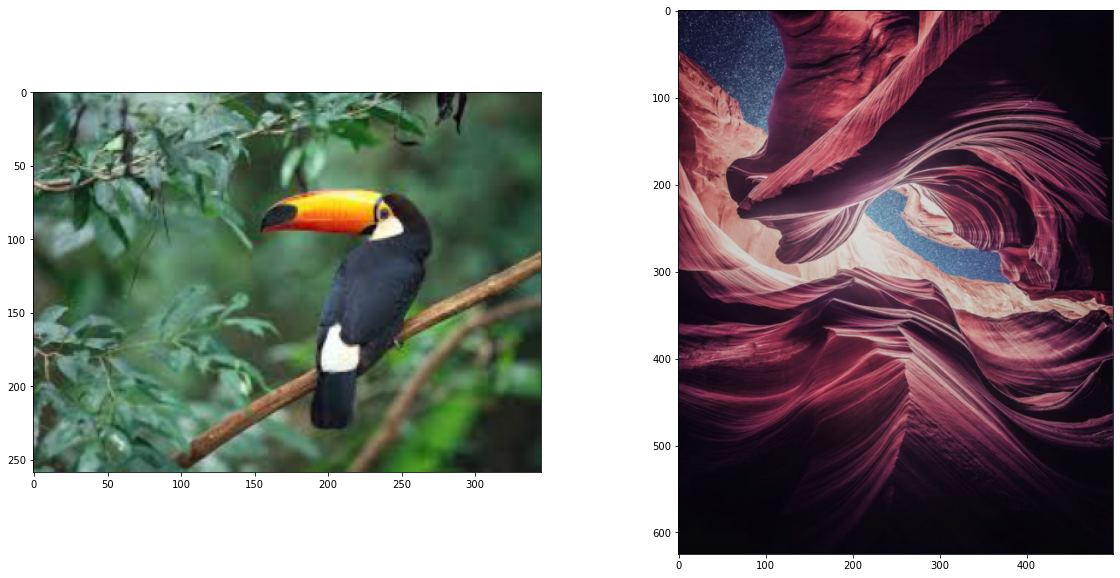

In [52]:
# Plot the image after processing and deprocessing it..original

fig, (ax1,ax2) = plt.subplots(1,2,figsize = (20,10))

ax1.imshow(content_d)
ax2.imshow(style_d)


## Task 5 : Get content,style features and create gram matrix

In [70]:
# Get content, style feature and create a gram matrix

def get_features(image,model):

  layers = {
      
      '0' : 'conv1_1',
      '5'  : 'conv2_1',
      '10' : 'conv3_1',
      '19' : 'conv4_1',
      '21' : 'conv4_2',  #content feature
      '28' : 'conv5_1'
  }

  x = image
  Features = {}

  for name,layer in model._modules.items():  #Used to layers from VGG19 model one by one

     x = layer(x) 
                   
     if name in layers:

       Features[layers[name]] = x



  return Features

In [71]:
content_f = get_features(content_p,vgg)
style_f = get_features(style_p,vgg)



def gram_matrix(tensor):

  b,c,h,w = tensor.size()
  tensor = tensor.view(c,h*w)
  gram = torch.mm(tensor,tensor.t())
  return gram


style_grams = {layer : gram_matrix(style_f[layer])  for layer in style_f}


## Creating Style and Content loss function

In [72]:
# Create style and content loss function

def content_loss(target_conv4_2,content_conv4_2):

  loss = torch.mean((target_conv4_2-content_conv4_2)**2)
  return loss


In [73]:
style_weights = {
    'conv1_1' : 1.0,
    'conv2_1' : 0.75,
    'conv3_1' : 0.2,
    'conv4_1' : 0.2,
    'conv5_1' : 0.2

}



In [74]:
def style_loss(style_weights,target_features,style_grams):

  loss = 0

  for layer in style_weights:
    target_f = target_features[layer]
    target_gram = gram_matrix(target_f)
    style_gram = style_grams[layer]
    b,c,h,w = target_f.shape
    layer_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
    loss += layer_loss/(c*h*w)

  return loss  


In [76]:
target = content_p.clone().requires_grad_(True).to(device)
target_f = get_features(target,vgg)
print("Content Loss : ",content_loss(target_f['conv4_2'],content_f['conv4_2']))
print("Style Loss : ",style_loss(style_weights,target_f,style_grams))



Content Loss :  tensor(0., grad_fn=<MeanBackward0>)
Style Loss :  tensor(1790.8411, grad_fn=<AddBackward0>)


## Training

In [77]:
from torch import optim

optimizer = optim.Adam([target],lr=0.003)

alpha = 1
beta = 1e5

epochs = 3000
show_every = 500

def total_loss(c_loss,s_loss,alpha,beta):
   loss = alpha * c_loss + beta * s_loss
   return loss


In [78]:
results = []

for i in range(epochs):

  target_f = get_features(target,vgg)

  c_loss = content_loss(target_f['conv4_2'],content_f['conv4_2'])
  s_loss = style_loss(style_weights,target_f,style_grams)
  t_loss = total_loss(c_loss,s_loss,alpha,beta)
  
  optimizer.zero_grad()
  t_loss.backward()
  optimizer.step()
  

  if i % show_every == 0:
    print("Total Loss at Epoch {} : {}".format(i,t_loss))
    results.append(deprocess(target.detach()))



Total Loss at Epoch 0 : 179084112.0
Total Loss at Epoch 500 : 27114756.0
Total Loss at Epoch 1000 : 15137339.0
Total Loss at Epoch 1500 : 11676281.0
Total Loss at Epoch 2000 : 9609601.0
Total Loss at Epoch 2500 : 8199902.0


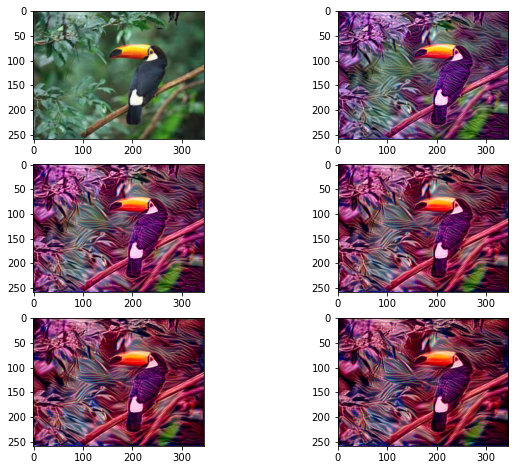

In [79]:
# print the image after styling

plt.figure(figsize = (10,8))

for i in range(len(results)):
 
    plt.subplot(3,2,i+1)
    plt.imshow(results[i])
plt.show()

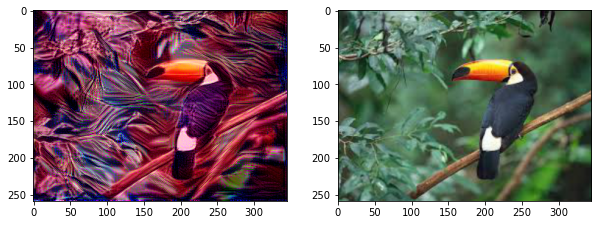

In [80]:
target_copy = deprocess(target.detach())
content_copy = deprocess(content_p)

fig,(ax1,ax2) = plt.subplots(1,2,figsize = (10,5))
ax1.imshow(target_copy)
ax2.imshow(content_copy)
